In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy import stats
import pandas as pd
from scipy import optimize
from scipy.special import factorial2
from scipy import special
from scipy.integrate import quad
import random
from tqdm import tqdm
import warnings
from scipy import interpolate
warnings.filterwarnings('ignore')

## import data

In [4]:
option = pd.read_csv('beta00_alpha10/filtered_SSE50Option.csv')
prc = pd.read_csv('Other empirics/SSE RV.csv')
prc.RV = prc.RV/100
prc.Trddt = pd.to_datetime(prc['Trddt'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
prc = prc.rename(columns={"Trddt": "Date"})
prc = prc.dropna(subset=['RV'])
prc = prc[prc.Date>'2015-02-01']
prc = prc[prc.Date<'2022-12-31']

RV = prc.copy()

## compute model-based BSM IV

In [5]:
DN05 = pd.read_csv('beta00_alpha05/fitted_value_05.csv')
DN05 = np.array(DN05.model_price)
DN10 = pd.read_csv('beta00_alpha10/fitted_value_10.csv')
DN10 = np.array(DN10.model_price)
DN0505 = pd.read_csv('beta00_alpha0505/fitted_value_0505.csv')
DN0505 = np.array(DN0505.model_price)
DN1010 = pd.read_csv('beta00_alpha1010/fitted_value_1010.csv')
DN1010 = np.array(DN1010.model_price) 

In [8]:
%%time
option['DN05_prc'] = DN05
option['DN10_prc'] = DN10
option['DN0505_prc'] = DN0505
option['DN1010_prc'] = DN1010

option['DN05_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN05_prc']),axis=1)
option['DN10_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN10_prc']),axis=1)
option['DN0505_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN0505_prc']),axis=1)
option['DN1010_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['DN1010_prc']),axis=1)
option['market_iv'] = option.apply(lambda x: implied_volatility(x['close'], x['StrikePrice'], 
                                                                x['TTM'], x['RisklessRate'], 0, x['mid_price']),axis=1)

CPU times: user 3min 48s, sys: 3.07 s, total: 3min 51s
Wall time: 3min 49s


## plot fitted IV smirk across maturity bins

In [10]:
def iv_plot_by_group(option, IV_colname):
    n_points = 6
    mnes_min = 0.88
    mnes_max = 1.12
    
    DTM_con1 = (option.days<30)
    subSample = option[DTM_con1]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid1 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid1[i-1] = np.mean(subsubSample[IV_colname])
        
    
    DTM_con2 = (option.days>=30) & (option.days<90)
    subSample = option[DTM_con2]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid2 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid2[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con3 = (option.days>=90) & (option.days<180)
    subSample = option[DTM_con3]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid3 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid3[i-1] = np.mean(subsubSample[IV_colname])
        
    DTM_con4 = (option.days>=180)
    subSample = option[DTM_con4]
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid4 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid4[i-1] = np.mean(subsubSample[IV_colname])
        
    return mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4

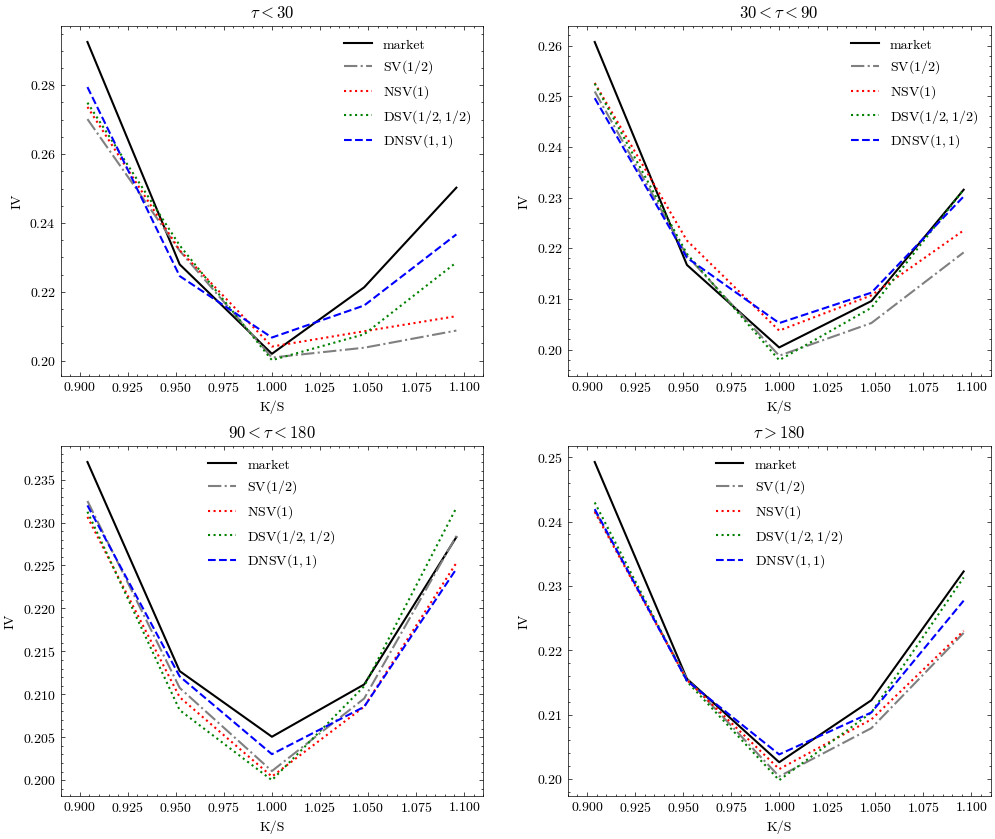

In [14]:
optionS = option.copy()
mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4 = iv_plot_by_group(optionS, 'ImpliedVolatility')
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(mnes_mid,iv_mid1,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid1_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$\\tau<30$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(222)
plt.plot(mnes_mid,iv_mid2,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid2_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$30<\\tau<90$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(223)
plt.plot(mnes_mid,iv_mid3,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$90<\\tau<180$')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(224)
plt.plot(mnes_mid,iv_mid4,color='black',label='market', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_10,color='red',linestyle='dotted',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_1010,color='blue',linestyle='dashed',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV')
plt.title('$\\tau>180$')
plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('fit_average_iv.eps',dpi=400)

## mplot fitting error across maturity bins

In [15]:
def iv_plot_by_group(option, IV_colname):
    '''
    IV error against moneyness
    '''
    n_points = 6
    mnes_min = 0.88
    mnes_max = 1.12

    ## mean error
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid1 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid1[i-1] = np.mean(subsubSample[IV_colname]-subsubSample['market_iv'])
        
    ## mean absolute error
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid2 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid2[i-1] = np.mean(np.abs(subsubSample[IV_colname]-subsubSample['market_iv']))

    ## mean absolute percentage error
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid3 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid3[i-1] = np.mean(np.abs(subsubSample[IV_colname]-subsubSample['market_iv'])/subsubSample['market_iv'])

    ## RMSE
    subSample = option.copy()
    mnes_range = np.linspace(mnes_min,mnes_max,n_points)
    mnes_mid = np.zeros(len(mnes_range)-1)
    iv_mid4 = np.zeros_like(mnes_mid)
    for i in range(1,len(mnes_range)):
        left = mnes_range[i-1]
        rght = mnes_range[i]
        mnes_mid[i-1] = (left+rght)/2
        mnes_con = (subSample.mnes>=left) & (subSample.mnes<rght)
        subsubSample = subSample[mnes_con]
        iv_mid4[i-1] = np.sqrt(np.mean((subsubSample[IV_colname]-subsubSample['market_iv'])**2))
        
    return mnes_mid,iv_mid1,iv_mid2,iv_mid3,iv_mid4

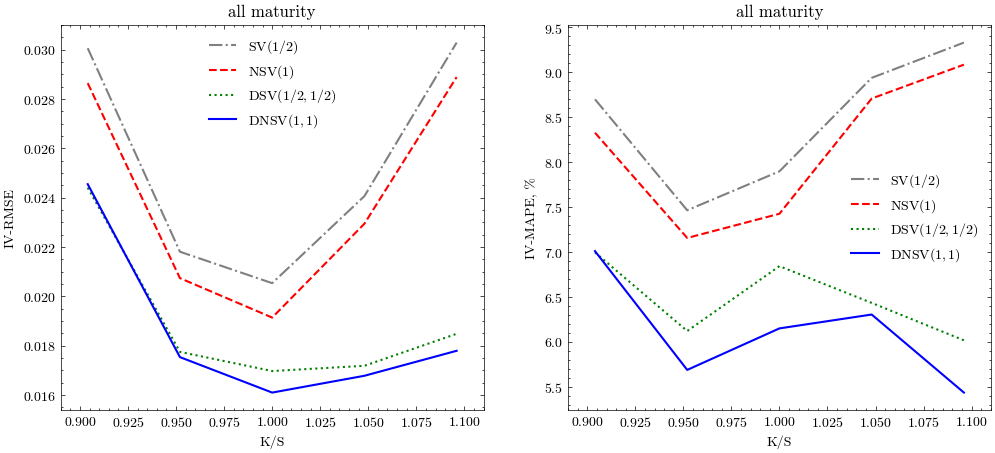

In [17]:
optionS = option.copy()
mnes_mid,iv_mid1_05,iv_mid2_05,iv_mid3_05,iv_mid4_05 = iv_plot_by_group(optionS, 'DN05_iv')
mnes_mid,iv_mid1_10,iv_mid2_10,iv_mid3_10,iv_mid4_10 = iv_plot_by_group(optionS, 'DN10_iv')
mnes_mid,iv_mid1_0505,iv_mid2_0505,iv_mid3_0505,iv_mid4_0505 = iv_plot_by_group(optionS, 'DN0505_iv')
mnes_mid,iv_mid1_1010,iv_mid2_1010,iv_mid3_1010,iv_mid4_1010 = iv_plot_by_group(optionS, 'DN1010_iv')

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(mnes_mid,iv_mid4_05,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_10,color='red',linestyle='dashed',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_0505,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid4_1010,color='blue',linestyle='-',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV-RMSE')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

plt.subplot(122)
plt.plot(mnes_mid,iv_mid3_05*100,color='gray',linestyle='dashdot',label='SV($1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_10*100,color='red',linestyle='dashed',label='NSV($1$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_0505*100,color='green',linestyle='dotted',label='DSV($1/2,1/2$)', linewidth=1.5)
plt.plot(mnes_mid,iv_mid3_1010*100,color='blue',linestyle='-',label='DNSV($1,1$)', linewidth=1.5)
plt.xlabel('K/S')
plt.ylabel('IV-MAPE, %')
plt.title('all maturity')
plt.xlim([0.89,1.11])
plt.legend()

plt.savefig('fit_average_ivrmse.eps',dpi=400)